In [3]:
%load_ext autoreload
%autoreload 1

In [4]:
import numpy as np
import scipy
import scipy.cluster
import scipy.io
import scipy.special
import matplotlib as mpl
import matplotlib.pyplot as plt

import sympy as sp

import lmfit
import numdifftools

import os
import sys
import time
from pathlib import Path
fun_lib_path = Path.home() / 'git/alexei_fun_lib' 
sys.path.append(str(fun_lib_path))

import collections

import optics_funs as of
import numerical_funs as nf
import matplotlib_funs as mpf
import LCT_funs as lctf
import general_funs as gef
import debug_funs as dgf
import stats_funs as sf
import wolfram_funs as wlf
import math_funs as mf

import beam_profiling

import new_types as nt
import mutants

In [5]:
def complex_cross_product(z1, z2):
    '''Treat complex numbers as vectors in R^2
    '''
    a,b = z1.real, z1.imag
    c,d = z2.real, z2.imag
    return a*d - b*c

def complex_dot_product(z1, z2):
    '''Treat complex numbers as vectors in R^2
    '''
    a,b = z1.real, z1.imag
    c,d = z2.real, z2.imag
    return a*c + b*d

In [489]:

@lambda x: np.vectorize(x, signature='(k),(k)->()')
def area_of_2_vectors(v1, v2):
    '''
    Compute area of two vectors by first finding their orthgonal components using SVD
    Then use area of ellipse formula.
    '''
    stack = np.vstack([v1,v2])
    U,S,V = np.linalg.svd(stack)
    area = np.pi * np.product(np.abs(S))
    return area

@lambda x: np.vectorize(x, signature='(k),(k)->()')
def area_of_2_vectors(v1, v2):
    '''
    Compute area of two vectors by first finding their orthgonal components using SVD
    Then use area of ellipse formula.
    '''
    stack = np.vstack([v1,v2])
    U,S,V = np.linalg.svd(stack)
    area = np.pi * np.min(np.abs(S))
    return area

In [490]:
# visually inspect solution

q_target = 0.47 + 0.25j

liquid_lens_powers = np.linspace(-1.5, 3.5, 101)
liquid_lens_offsets = np.linspace(0, 30e-2, 100)

ltp = of.abcd.lens_p(liquid_lens_powers)
lto1 = of.abcd.space(liquid_lens_offsets)
lto2 = 30e-2 - lto1
m_lt = lto2@gef.outer_matmul(ltp, lto1)
m_lt = np.transpose(m_lt, [1,0,2,3])

def evaluation_function1(X):
    z_in, zr_in, z_out, lt_power, lt_offset = X
    q_in = z_in + zr_in*1j
    
    lto1 = lt_offset
    lto2 = 30e-2 - lt_offset
    ltp = lt_power
    
    do = 1e-6
    dp = 1e-6
    
    m = of.abcd.space(z_out)@of.abcd.space(lto2)@of.abcd.lens_p(ltp)@of.abcd.space(lto1)
    m_dp = of.abcd.space(z_out)@of.abcd.space(lto2)@of.abcd.lens_p(ltp+dp)@of.abcd.space(lto1)
    m_do = of.abcd.space(z_out)@of.abcd.space(lto2-do)@of.abcd.lens_p(ltp)@of.abcd.space(lto1+do)
    
    # gradient normalization to actuation range
    norm_p = 3.5 - (-1)
    norm_o = 30e-2 - 0
    
    q_out = of.q.propag(q_in, m)
    q_out_dp = (q_out-of.q.propag(q_in, m_dp))/dp * norm_p
    q_out_do = (q_out-of.q.propag(q_in, m_do))/do * norm_o
    
    a_mm = of.mode_mismatch(q_out, q_target)
    return a_mm, q_out_dp, q_out_do

def evaluation_function2(X, powers, offsets, return_type='mismatch'):
    z_in, zr_in, z_out, q_target = X
    q_in = z_in + zr_in*1j
    m_z_out = of.abcd.space(z_out)
    
    ltp = of.abcd.lens_p(np.atleast_1d(powers))
    lto1 = of.abcd.space(np.atleast_1d(offsets))
    lto2 = of.abcd.space(30e-2-np.atleast_1d(offsets))
    m_lt = lto2@gef.outer_matmul(ltp, lto1)
    m_lt = np.transpose(m_lt, [1,0,2,3])
    
    m = m_z_out@m_lt
    q_out = of.q.propag(q_in, m)
    mismatch = of.mode_mismatch(q_out, q_target)
    if return_type == 'mismatch':
        return mismatch
    elif return_type == 'q_out':
        return q_out

In [491]:
def objective_function(X, q_target, return_scores=False):
    z_in, zr_in, z_out = X
    if zr_in < 0:
        return np.inf
    q_in = z_in + zr_in*1j
    
    lt_power = 1
    lt_offset = 15e-2
    
    do = 1e-6
    dp = 1e-6
    
    lto1 = lt_offset
    lto2 = 30e-2 - lt_offset
    ltp = lt_power
    
    m = of.abcd.space(z_out)@of.abcd.space(lto2)@of.abcd.lens_p(ltp)@of.abcd.space(lto1)
    m_dp = of.abcd.space(z_out)@of.abcd.space(lto2)@of.abcd.lens_p(ltp+dp)@of.abcd.space(lto1)
    m_do = of.abcd.space(z_out)@of.abcd.space(lto2-do)@of.abcd.lens_p(ltp)@of.abcd.space(lto1+do)
    
    norm_p = 3.5 - (-1)
    norm_o = 30e-2 - 0
    
    q_out = of.q.propag(q_in, m)
    q_out_dp = (q_out-of.q.propag(q_in, m_dp))/dp*norm_p
    q_out_do = (q_out-of.q.propag(q_in, m_do))/do*norm_o
    
    ac = np.abs(complex_cross_product(q_out_dp, q_out_do))
    ag = np.abs(q_out_dp)*np.abs(q_out_do)
    an = 1/2 * (np.abs(q_out_dp)**2 + np.abs(q_out_do)**2)
    ad = np.abs(complex_dot_product(q_out_dp, q_out_do))
    aa = (1-ad/an)
    
    a_area = np.abs(q_out_dp)*np.abs(q_out_do)*aa
    
    v_area = (area_of_2_vectors(nf.complex_to_R2(q_out_dp),nf.complex_to_R2(q_out_do)))
    a_area = np.exp(-1/v_area)
    
    a_orth = ac**2/ag**2
    a_bal = ag/an
    overlap = 1 - of.mode_mismatch(q_out, q_target)
    a_ovl = np.exp((1-1/overlap))
    
    a_fom = a_ovl**1 * a_bal**5 * a_orth**2 * a_area**1
    
    if return_scores:
        return {'ovl': overlap, 'orth': a_orth, 'bal': a_bal, 'area': v_area}
    
    return -a_fom

In [492]:
q_target = 0.3j
z_out = 10e-2
X_init = [-0.2, 0.4]
X_init = [np.random.randn()*10, np.abs(np.random.randn()*10),np.random.randn()*10,]
X_init = np.array([ 0.14706646,  0.4383163 , -0.1743376 ])
bounds = [[-5,5], [1e-5, 5], [0.05, 3], [-1,3.5], [0,0.3]]

soln = scipy.optimize.minimize(objective_function, X_init, args=(q_target), method='Nelder-Mead')
# soln_de = scipy.optimize.differential_evolution(objective_function, bounds=bounds)

In [493]:
soln

 final_simplex: (array([[-0.10850084,  0.2208623 , -0.14067702],
       [-0.10851257,  0.22085569, -0.1406374 ],
       [-0.10850863,  0.22085162, -0.14074756],
       [-0.10851515,  0.22085519, -0.14075587]]), array([-0.04760981, -0.04760981, -0.04760981, -0.04760981]))
           fun: -0.047609809291442685
       message: 'Optimization terminated successfully.'
          nfev: 155
           nit: 88
        status: 0
       success: True
             x: array([-0.10850084,  0.2208623 , -0.14067702])

In [494]:
objective_function(soln.x, q_target, return_scores=True)

{'ovl': 0.9815691473410284,
 'orth': 0.9946174781720358,
 'bal': 0.8714562441719657,
 'area': array(0.42970143)}

In [495]:
mismatches_2 = evaluation_function2(np.r_[soln.x,q_target], liquid_lens_powers, liquid_lens_offsets)

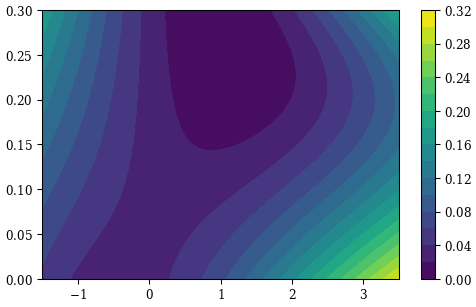

In [496]:
plt.contourf(liquid_lens_powers, liquid_lens_offsets, mismatches_2, levels=16)
plt.colorbar()

In [105]:
mpf.imshow(p1s,p2s, a_ovl**2 * a_orth**2 * a_bal**2 * a_area_1**0.5)

NameError: name 'p1s' is not defined

In [ ]:
mpf.imshow(p1s,p2s,a_orth**2 * a_bal**2 * a_area_1**0.5)

In [ ]:
mpf.imshow(p1s,p2s,a_orth**4 * ag * (1-a_bal))

In [ ]:
mpf.imshow(p1s,p2s,ac**4/an**4*ag)

In [ ]:
mpf.imshow(p1s,p2s,(a_cross/a_mag)**2*a_geom)

In [ ]:
q = 1j
d = 1
p1s = np.linspace(1,5,171)
p2s = np.linspace(1,2,302)
dp1 = 1e-7
dp2 = 1e-7
p1sa = p1s+dp1
p2sa = p2s+dp2

s1 = of.abcd.space(d)
f1s = of.abcd.lens_p(p1s)
f2s = of.abcd.lens_p(p2s)
f1sa = of.abcd.lens_p(p1sa)
f2sa = of.abcd.lens_p(p2sa)

ms = gef.outer_matmul(f2s,s1@f1s)
ms1a = gef.outer_matmul(f2s,s1@f1sa)
ms2a = gef.outer_matmul(f2sa,s1@f1s)

q2s = of.q.propag(q,ms)
q2s1a = of.q.propag(q,ms1a)
q2s2a = of.q.propag(q,ms2a)

In [ ]:
dp1s = (q2s-q2s1a)/dp1
dp2s = (q2s-q2s2a)/dp2

In [ ]:
a_cross = np.abs(complex_cross_product(dp1s,dp2s))**2
a_mag = np.abs(dp1s)**2 * np.abs(dp2s)**2
a_geom = np.sqrt(np.abs(dp1s)*np.abs(dp2s))

In [ ]:
mpf.imshow(p1s,p2s,(a_cross/a_mag))

In [ ]:
mpf.imshow(p1s,p2s,(a_cross/a_mag)**(2)*a_geom)

In [ ]:
mpf.complex_imshow(q2s)

In [ ]:
plt.contourf(liquid_lens_powers, liquid_lens_offsets, mismatches_2, levels=11)
mpf.forceAspect()
plt.colorbar()